In [1]:
import argparse
import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt
from IdealDataInterface import IdealDataInterface

In [2]:
def get_data(path,home_id):
    # 初始化数据接口
    idi = IdealDataInterface(path)
    # 获取所有家用电器使用数据
    readings = idi.get(homeid=home_id,category='electric-appliance')
    
    return readings

Found entries for 51 sensor readings.


100%|██████████| 100/100 [02:18<00:00,  1.38s/it] 

['dishwasher', 'washingmachinetumbledrier', 'vacuumcleaner', 'electricheater', 'toaster', 'other', 'microwave', 'fridgefreezer', 'grill']


AttributeError: 'int' object has no attribute 'pop'

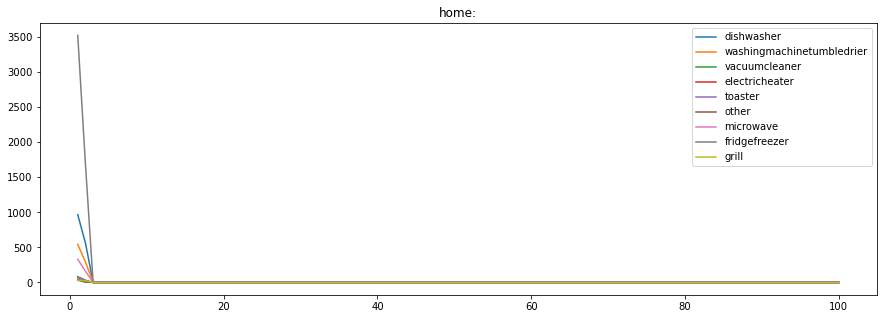

In [5]:
# 所有家庭分别显示(coding)
def concat_data(readings,time_cell='300'):
    # 将数据展示在图表上
    rlist=[]
    legend=[]
    for res in readings:
        rlist.append(res['readings'].resample(time_cell+"s").mean().ffill()) #得出平均功率
        legend.append(res['subtype'])
        
    combo=pd.concat(rlist, axis=1).fillna(0)
    combo.set_axis(legend, axis='columns', inplace=True) # 修改列名
    return (combo,legend)


ideal_home = [169]
ideal_path = '../IDEAL/'

results = {}
for home in ideal_home:
    readings = get_data(ideal_path,home)
    data,legend = concat_data(readings)
    sub_df_dic = {}
    for i in range(1,101):
        sub_df_dic[i] = data.iloc[round(len(data)/2*(i-1)):round(len(data)/1*i)]
    result = {}
    for k,v in tqdm(sub_df_dic.items()):  # 对每5%df的值进行计算   k:[1,2,3,4,...,20]
        values_dic = {}
        v.reset_index(inplace=True) # v.columns:[time,d1,d2,d3...]
        for name in legend:
            time_sum = 0
            df = v[['time',name]]
            start_node = 0
            for i in range(0, len(df)):
                if start_node == 0 and df.iloc[i][name] != 0:
                    start_node = df.iloc[i]['time']
                elif start_node != 0 and df.iloc[i][name] == 0:
                    time_sum += (df.iloc[i-1]['time'] - start_node).seconds
                    start_node = 0
                if start_node !=0 and i == (len(df)-1):
                    time_sum += (df.iloc[i]['time'] - start_node).seconds
            values_dic[name] = time_sum /3600
        result[k] = values_dic
    results[home] = result
    
for home,result in results.items():
    tmp_list = [v for k,v in result.items()]
    # tmp_dic = [{k:v} for i in tmp_list for k,v in i.items()]
    keys = list(tmp_list[0].keys())
    print(keys)
    r_dic = {}
    for key in keys:
        r_dic[key] = []
    for sub_dict in tmp_list:
        for key in keys:
            r_dic[key].append(sub_dict[key])
    df = pd.DataFrame(r_dic)
    df.index = df.index + 1
    plt.figure(figsize=(15, 5))
    plt.plot(df)
    plt.legend(keys)
    plt.title('home:',home)
    plt.show()